In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# chargement des données

In [4]:
df = pd.read_feather('cleaned_data_jointed.feather')

# Segmentation RFM

RFM = Récence, Fréquence et Montant.

    - La Récence: Combien de temps s’est-il écoulé depuis la dernière activité du client ?
    - Fréquence: Au cours d’une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ?
    - Le Montant (en anglais « monetary »). Combien un client a-t-il dépensé d’argent au cours d’une période de temps donnée ?


In [5]:
selected_cols = ['order_id','order_purchase_timestamp','customer_unique_id','customer_city','payment_installments',
                'payment_type','price','review_score','product_category_name_english','payment_value','freight_value'
                ,'shipping_limit_date']

In [6]:
data = df[selected_cols]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106776 entries, 0 to 106775
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       106776 non-null  object        
 1   order_purchase_timestamp       106776 non-null  datetime64[ns]
 2   customer_unique_id             106776 non-null  object        
 3   customer_city                  106776 non-null  object        
 4   payment_installments           106776 non-null  float64       
 5   payment_type                   106776 non-null  object        
 6   price                          106776 non-null  float64       
 7   review_score                   106776 non-null  float64       
 8   product_category_name_english  106776 non-null  object        
 9   payment_value                  106776 non-null  float64       
 10  freight_value                  106776 non-null  float64       
 11  

In [8]:
data.describe()

payment_installments          price   review_score  payment_value  \
count         106776.000000  106776.000000  106776.000000  106776.000000   
mean               2.884731     109.931796       4.092802     154.862762   
std                2.646877     124.573531       1.335955     159.045992   
min                1.000000       8.000000       1.000000       3.020000   
25%                1.000000      39.900000       4.000000      61.610000   
50%                2.000000      74.000000       5.000000     107.635000   
75%                4.000000     129.990000       5.000000     185.140000   
max               10.000000    1209.000000       5.000000    1404.240000   

       freight_value  
count  106776.000000  
mean       19.360110  
std        12.051766  
min         1.270000  
25%        13.150000  
50%        16.310000  
75%        21.100000  
max       106.210000

In [9]:
data["customer_unique_id"].value_counts().count()

87985

## RFM

Habituellement, en marketing, la date de référence est la date de dernière transaction plus 1 jour

In [10]:
import datetime
max_date = max(data.order_purchase_timestamp) + datetime.timedelta(days=1)

In [11]:
max_date

Timestamp('2018-08-30 15:00:37')

In [12]:
data['order_purchase_timestamp'][0]

Timestamp('2017-10-02 10:56:33')

In [13]:
rfm_custom = data.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (max_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})

In [14]:
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
rfm_custom

Recency  Frequency  MonetaryValue
customer_unique_id                                                 
0000366f3b9a7992bf8c76cfdf3221e2      112          1         141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          27.19
0000f46a3911fa3c0805444483337064      537          1          86.22
0000f6ccb0745a6a4b88665a16c9f078      321          1          43.62
0004aac84e0df4da2b147fca70cf8255      288          1         196.89
...                                   ...        ...            ...
fffb09418989a0dbff854a28163e47c6      255          1          73.16
fffea47cd6d3cc0a88bd621562a9d061      262          1          84.58
ffff371b4d645b6ecea244b27531430a      568          1         112.46
ffff5962728ec6157033ef9805bacc48      119          1         133.69
ffffd2657e2aad2907e67c3e9daecbeb      484          1          71.56

[87985 rows x 3 columns]

In [15]:
rfm_custom['Frequency'].value_counts()

1     75171
2      9582
3      1748
4       804
5       493
6        75
8        31
10       28
7        24
12        9
9         8
15        5
20        3
14        2
16        1
11        1
Name: Frequency, dtype: int64

## RFM scores

In [16]:
df_quantiles_f = rfm_custom.Frequency.quantile(q=[0.25, 0.5, 0.75])
df_quantiles_f

0.25    1.0
0.50    1.0
0.75    1.0
Name: Frequency, dtype: float64

In [17]:
def F_score(x): #  [ 4,8,12]
    if x <= 4:
        return 1
    elif x <= 8:
        return 2
    elif x <= 12:
        return 3
    else:
        return 4  
    

In [18]:
rfm_custom["R"] = pd.qcut(rfm_custom["Recency"],5,labels=[5,4,3,2,1])
rfm_custom["F"] = rfm_custom["Frequency"].apply(F_score)
rfm_custom["M"] = pd.qcut(rfm_custom["MonetaryValue"],5,labels=[1,2,3,4,5])
rfm_custom["RFM_Score"] = rfm_custom["R"].astype(str) +rfm_custom["F"].astype(str) + rfm_custom["M"].astype(str)
rfm_custom

Recency  Frequency  MonetaryValue  R  F  M  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1         141.90  4  1  4   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          27.19  4  1  1   
0000f46a3911fa3c0805444483337064      537          1          86.22  1  1  3   
0000f6ccb0745a6a4b88665a16c9f078      321          1          43.62  2  1  1   
0004aac84e0df4da2b147fca70cf8255      288          1         196.89  2  1  5   
...                                   ...        ...            ... .. .. ..   
fffb09418989a0dbff854a28163e47c6      255          1          73.16  3  1  2   
fffea47cd6d3cc0a88bd621562a9d061      262          1          84.58  3  1  3   
ffff371b4d645b6ecea244b27531430a      568          1         112.46  1  1  3   
ffff5962728ec6157033ef9805bacc48      119          1         133.69  4  1  4   
ffffd2657e2aad2907e67c3e9daecbeb      484          1          71.56  1  1  2   

                                 RFM_Score  
customer_unique_id                          
0000366f3b9a7992bf8c76cfdf3221e2       414  
0000b849f77a49e4a4ce2b2a4ca5be3f       411  
0000f46a3911fa3c0805444483337064       113  
0000f6ccb0745a6a4b88665a16c9f078       211  
0004aac84e0df4da2b147fca70cf8255       215  
...                                    ...  
fffb09418989a0dbff854a28163e47c6       312  
fffea47cd6d3cc0a88bd621562a9d061       313  
ffff371b4d645b6ecea244b27531430a       113  
ffff5962728ec6157033ef9805bacc48       414  
ffffd2657e2aad2907e67c3e9daecbeb       112  

[87985 rows x 7 columns]

Obeservation: 5 X 4 X 5

Meilleur score de récence : 5 : le dernier achat est le plus récent.

Meilleur score de fréquence : 4 : les achats sont les plus fréquents.

Meilleur score de montant : 5 : le montant le plus élevé donc client dépensier.

In [19]:
rfm_custom['F'].value_counts()

1    87305
2      623
3       46
4       11
Name: F, dtype: int64

In [20]:
rfm_custom['R+mean_FM'] = rfm_custom["R"].astype(str)+rfm_custom[['F', 'M']].mean(axis=1).round().astype(int).astype(str)
rfm_custom.reset_index()

customer_unique_id  Recency  Frequency  MonetaryValue  R  \
0      0000366f3b9a7992bf8c76cfdf3221e2      112          1         141.90  4   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          27.19  4   
2      0000f46a3911fa3c0805444483337064      537          1          86.22  1   
3      0000f6ccb0745a6a4b88665a16c9f078      321          1          43.62  2   
4      0004aac84e0df4da2b147fca70cf8255      288          1         196.89  2   
...                                 ...      ...        ...            ... ..   
87980  fffb09418989a0dbff854a28163e47c6      255          1          73.16  3   
87981  fffea47cd6d3cc0a88bd621562a9d061      262          1          84.58  3   
87982  ffff371b4d645b6ecea244b27531430a      568          1         112.46  1   
87983  ffff5962728ec6157033ef9805bacc48      119          1         133.69  4   
87984  ffffd2657e2aad2907e67c3e9daecbeb      484          1          71.56  1   

       F  M RFM_Score R+mean_FM  
0      1  4       414        42  
1      1  1       411        41  
2      1  3       113        12  
3      1  1       211        21  
4      1  5       215        23  
...   .. ..       ...       ...  
87980  1  2       312        32  
87981  1  3       313        32  
87982  1  3       113        12  
87983  1  4       414        42  
87984  1  2       112        12  

[87985 rows x 9 columns]

## Segmentation 

In [21]:
seg_map = {
    r'[4-5][4-5]': 'Champion',
    r'[2-5][3-5]': 'fidèle',
    r'[3-5][1-3]': 'potentiellement fidèle',
    r'[4-5][0-1]' : 'récent',
    r'[3-4][0-1]':'prometteur',
    r'[2-3][2-3]':'mérite une attention',
    r'[2-3][0-2]':'sur le point de s’endormir',
    r'[0-2][2-5]' :'à risque',
    r'[0-1][4-5]':'à ne pas perdre',
    r'[1-2][1-2]':'en hibernation',
    r'[0-2][0-2]':'perdus'

}


actions = {
    'Champion':'Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.',
    'fidèle':'Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.',
    'potentiellement fidèle':'Proposez-leur de rejoindre votre programme de fidélité / membres. Recommandez-leur d’autres produits.',
    'récent':'Envoyez-leur un programme d’onboarding. Construisez une relation clients.',
    'prometteur':'Faites-leur découvrir vos produits, vos services, votre marque. Offrez-leur une période d’essai.',
    'mérite une attention':'Offrez-leur des offres limitées dans le temps. Faites-leur des recommandations basées sur leurs achats passés. Réactivez-les.',
    'sur le point de s’endormir':'Partagez-leur des ressources de valeur, recommandez-leur des produits populaires, des promotions sur leur renouvellement. Reconnectez avec eux.',
    'à risque':'Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.',
    'à ne pas perdre':'Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur.',
    'en hibernation':'Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.',
    'perdus':'Essayez de réveiller leur intérêt avec une campagne, sinon laissez tomber.'
    }

segment_caract = {
    'Champion':'A acheté récemment, achète souvent et dépense le plus.',
    'fidèle': 'Dépense pas mal d’argent et assez souvent. Sensible aux promotions.',
    'potentiellement fidèle': 'Client récent, mais qui a dépensé une bonne somme d’argent et acheté plus d’une fois.',
    'récent': 'A acheté récemment mais n’achète pas souvent.',
    'prometteur':'Acheteur récent, mais qui n’a pas dépensé beaucoup.',
    'mérite une attention':'Au-dessus de la moyenne concernant à la fois la récence, la fréquence et le montant. Mais n’a pas forcément acheté récemment.',
    'sur le point de s’endormir': 'En-dessous de la moyenne concernant à la fois la récence, la fréquence et le montant. Bientôt perdu si vous ne le réactivez pas.',
    'à risque':'A dépensé beaucoup d’argent et acheté souvent…mais il y a très longtemps. Vous devez les faire revenir à vous !',
    'à ne pas perdre':'A fait les plus gros achats et acheté souvent. Mais cela fait un moment qu’il n’a plus racheté.',
    'en hibernation':'Son dernier achat remonte à il y a moment…Ne dépense pas beaucoup et pas souvent du tout.',
    'perdus':'A les plus faibles scores en Récence, Fréquence et Montant.'
}
rfm_custom['segment'] = rfm_custom['R+mean_FM'].replace(seg_map, regex=True)
rfm_custom =rfm_custom.reset_index()
rfm_custom

customer_unique_id  Recency  Frequency  MonetaryValue  R  \
0      0000366f3b9a7992bf8c76cfdf3221e2      112          1         141.90  4   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          27.19  4   
2      0000f46a3911fa3c0805444483337064      537          1          86.22  1   
3      0000f6ccb0745a6a4b88665a16c9f078      321          1          43.62  2   
4      0004aac84e0df4da2b147fca70cf8255      288          1         196.89  2   
...                                 ...      ...        ...            ... ..   
87980  fffb09418989a0dbff854a28163e47c6      255          1          73.16  3   
87981  fffea47cd6d3cc0a88bd621562a9d061      262          1          84.58  3   
87982  ffff371b4d645b6ecea244b27531430a      568          1         112.46  1   
87983  ffff5962728ec6157033ef9805bacc48      119          1         133.69  4   
87984  ffffd2657e2aad2907e67c3e9daecbeb      484          1          71.56  1   

       F  M RFM_Score R+mean_FM                     segment  
0      1  4       414        42      potentiellement fidèle  
1      1  1       411        41      potentiellement fidèle  
2      1  3       113        12                    à risque  
3      1  1       211        21  sur le point de s’endormir  
4      1  5       215        23                      fidèle  
...   .. ..       ...       ...                         ...  
87980  1  2       312        32      potentiellement fidèle  
87981  1  3       313        32      potentiellement fidèle  
87982  1  3       113        12                    à risque  
87983  1  4       414        42      potentiellement fidèle  
87984  1  2       112        12                    à risque  

[87985 rows x 10 columns]

In [22]:
rfm_custom['segment'].value_counts()

potentiellement fidèle        42359
fidèle                        14025
à risque                      13912
mérite une attention          10638
en hibernation                 3612
sur le point de s’endormir     3268
Champion                        171
Name: segment, dtype: int64

7/11 segments trouvé

In [23]:
# Résumé : 
rfm_summury = rfm_custom[["segment", "Recency", "Frequency", "MonetaryValue"]].groupby("segment").agg(["mean", "count"]).reset_index()
rfm_summury

segment     Recency        Frequency         \
                                     mean  count      mean  count   
0                    Champion   98.906433    171  5.672515    171   
1              en hibernation  470.986711   3612  1.146733   3612   
2                      fidèle  178.249269  14025  1.369055  14025   
3        mérite une attention  315.736417  10638  1.185655  10638   
4      potentiellement fidèle  133.999386  42359  1.158573  42359   
5  sur le point de s’endormir  315.092105   3268  1.144125   3268   
6                    à risque  467.822024  13912  1.224482  13912   

  MonetaryValue         
           mean  count  
0    484.135659    171  
1     38.319674   3612  
2    357.070664  14025  
3    107.456204  10638  
4     91.824296  42359  
5     38.481184   3268  
6    168.281908  13912

dans ce dataset nous avons 7 types de clients: Champion, fidèle, en hibernation, fidèle, mérite une attention	,potentiellement fidèle,sur le point de s’endormir,à risque.

- les clients champion ont passé des commandes il y a en moyen 99 jours, commander 6 fois et dépenser en moyenne 484 réaux.

## Actions commerciales

In [24]:
customer_segment = pd.DataFrame()
customer_segment['segment'] = rfm_summury['segment']
customer_segment['nombre de client'] =  rfm_summury['Recency']['count']
customer_segment['moyen de  fréquence'] =  rfm_summury['Frequency']['mean'].round()
customer_segment['description'] = customer_segment['segment'].map(segment_caract)
customer_segment['action'] = customer_segment['segment'].map(actions)
customer_segment

segment  nombre de client  moyen de  fréquence  \
0                    Champion               171                  6.0   
1              en hibernation              3612                  1.0   
2                      fidèle             14025                  1.0   
3        mérite une attention             10638                  1.0   
4      potentiellement fidèle             42359                  1.0   
5  sur le point de s’endormir              3268                  1.0   
6                    à risque             13912                  1.0   

                                         description  \
0  A acheté récemment, achète souvent et dépense ...   
1  Son dernier achat remonte à il y a moment…Ne d...   
2  Dépense pas mal d’argent et assez souvent. Sen...   
3  Au-dessus de la moyenne concernant à la fois l...   
4  Client récent, mais qui a dépensé une bonne so...   
5  En-dessous de la moyenne concernant à la fois ...   
6  A dépensé beaucoup d’argent et acheté souvent…...   

                                              action  
0  Récompensez-les. Ils peuvent devenir des early...  
1  Offrez-leur des promotions spéciales, présente...  
2  Proposez-leur des produits de gamme supérieure...  
3  Offrez-leur des offres limitées dans le temps....  
4  Proposez-leur de rejoindre votre programme de ...  
5  Partagez-leur des ressources de valeur, recomm...  
6  Envoyez-leur des emails personnalisés pour rec...

## RFM Visualisation 

Text(0, 0.5, 'Nombre de clients par segments')

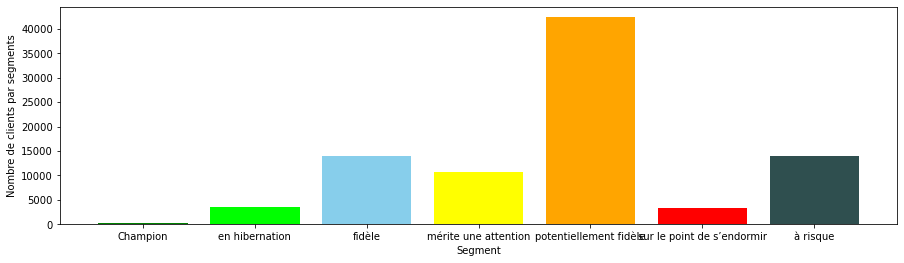

In [23]:
plt.figure(figsize=(15, 4))
plt.bar( customer_segment["segment"], customer_segment["nombre de client"], align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange", "red", "#2F4F4F"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

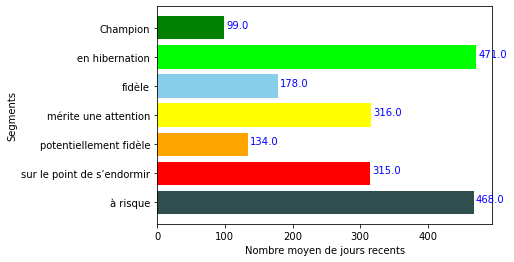

In [24]:
fig, ax = plt.subplots() 
ax.barh(customer_segment["segment"][::-1] , customer_segment["moyen de jours récent"][::-1],
        color=["#2F4F4F", "red", "orange", "yellow","#87ceeb", "lime", "green"]
       )
plt.xlabel('Nombre moyen de jours recents')
plt.ylabel('Segments')
for i, v in enumerate(customer_segment["moyen de jours récent"][::-1]):
    ax.text(v + 3, i + .0, str(v), color='blue')

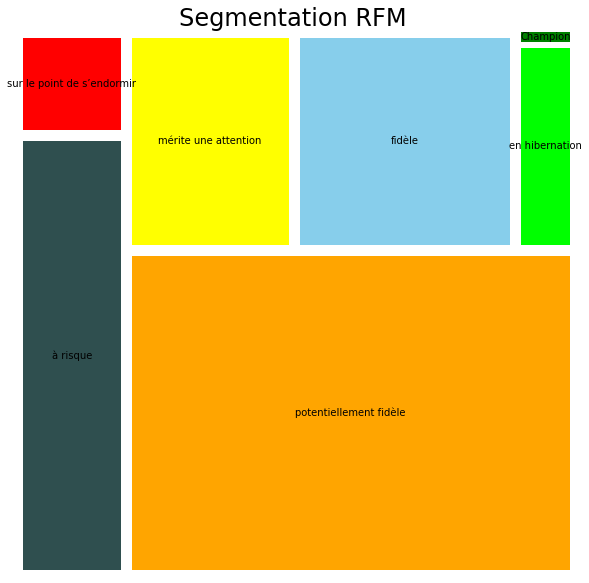

In [25]:
import squarify
fig, ax = plt.subplots(1, figsize = (10,10))

squarify.plot(sizes=customer_segment['nombre de client'][::-1], 
              label=customer_segment['segment'][::-1], 
              pad=2,
              color=["#2F4F4F", "red", "orange", "yellow","#87ceeb", "lime", "green"]
             )
plt.title("Segmentation RFM ", fontsize=24)
plt.axis('off')
plt.show()

# Feature Engineering

Nous allons maintenant ajouter/créer/calculer de nouvelles variables à partir des informations que nous avons à notre disposition :

## Moyenne des achats pour chaque client

In [25]:
price_mean = df.groupby('customer_unique_id')['price'].mean()
df['mean_price'] = df['customer_unique_id'].map(price_mean)

## Moyenne du nombre des échéances de paiement

In [26]:
# Moyenne du nombre des échéances de paiement
installment_mean = round((df.groupby('customer_unique_id')['payment_installments'].mean()),2)
df['payment_installment_mean'] = df['customer_unique_id'].map(installment_mean)


## délais de livraison

In [27]:
df["delivery_delay"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

## délais estimé de livraison

In [28]:
df["delivery_delay_estimation"] = (df["order_estimated_delivery_date"]- df["order_purchase_timestamp"]).dt.days

## moyenne des review_score

In [29]:
review_score = df.groupby('customer_unique_id')['review_score'].mean()
df['mean_review_score'] = df['customer_unique_id'].map(review_score)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106776 entries, 0 to 106775
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          106776 non-null  int64         
 1   order_id                       106776 non-null  object        
 2   customer_id                    106776 non-null  object        
 3   order_status                   106776 non-null  object        
 4   order_purchase_timestamp       106776 non-null  datetime64[ns]
 5   order_approved_at              106776 non-null  datetime64[ns]
 6   order_delivered_carrier_date   106776 non-null  datetime64[ns]
 7   order_delivered_customer_date  106776 non-null  datetime64[ns]
 8   order_estimated_delivery_date  106776 non-null  datetime64[ns]
 9   customer_unique_id             106776 non-null  object        
 10  customer_zip_code_prefix       106776 non-null  float64       
 11  

In [32]:
rfm_custom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87985 entries, 0 to 87984
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  87985 non-null  object  
 1   Recency             87985 non-null  int64   
 2   Frequency           87985 non-null  int64   
 3   MonetaryValue       87985 non-null  float64 
 4   R                   87985 non-null  category
 5   F                   87985 non-null  int64   
 6   M                   87985 non-null  category
 7   RFM_Score           87985 non-null  object  
 8   R+mean_FM           87985 non-null  object  
 9   segment             87985 non-null  object  
dtypes: category(2), float64(1), int64(3), object(4)
memory usage: 5.5+ MB


In [31]:
rfm_custom_1 = rfm_custom[['customer_unique_id','Recency','MonetaryValue']]
rfm_custom_1.head()

customer_unique_id  Recency  MonetaryValue
0  0000366f3b9a7992bf8c76cfdf3221e2      112         141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          27.19
2  0000f46a3911fa3c0805444483337064      537          86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          43.62
4  0004aac84e0df4da2b147fca70cf8255      288         196.89

In [32]:
rfm_custom_0 = df.groupby("customer_unique_id").agg({
    "delivery_delay" :"mean",
    "delivery_delay_estimation" : 'mean',
    "payment_installments" : "mean",
    "price" : "mean",
    "review_score":"mean"
})

In [35]:
rfm_custom_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87985 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   delivery_delay             87985 non-null  float64
 1   delivery_delay_estimation  87985 non-null  float64
 2   payment_installments       87985 non-null  float64
 3   price                      87985 non-null  float64
 4   review_score               87985 non-null  float64
dtypes: float64(5)
memory usage: 4.0+ MB


In [33]:
rfm_custom_0 = rfm_custom_0.rename(columns={'review_score': 'mean_review_score', 'price': 'mean_price'})

In [34]:
#rfm_custom_0 = pd.merge(rfm_custom_0,df[['customer_unique_id','mean_review_score']], on='customer_unique_id')
rfm_custom_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87985 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   delivery_delay             87985 non-null  float64
 1   delivery_delay_estimation  87985 non-null  float64
 2   payment_installments       87985 non-null  float64
 3   mean_price                 87985 non-null  float64
 4   mean_review_score          87985 non-null  float64
dtypes: float64(5)
memory usage: 4.0+ MB


In [35]:
rfm_custom_0_1 = pd.merge(rfm_custom_0,rfm_custom_1, on='customer_unique_id')

In [36]:
rfm_custom_0_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87985 entries, 0 to 87984
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         87985 non-null  object 
 1   delivery_delay             87985 non-null  float64
 2   delivery_delay_estimation  87985 non-null  float64
 3   payment_installments       87985 non-null  float64
 4   mean_price                 87985 non-null  float64
 5   mean_review_score          87985 non-null  float64
 6   Recency                    87985 non-null  int64  
 7   MonetaryValue              87985 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.0+ MB


In [37]:
rfm_custom_0_1 = rfm_custom_0_1.rename(columns={'payment_installments': 'mean_payment_installments',
                                                'delivery_delay': 'mean_delivery_delay',
                                               'delivery_delay_estimation':'mean_delivery_delay_estimation'})

In [38]:
rfm_custom_0_1.describe()

mean_delivery_delay  mean_delivery_delay_estimation  \
count         87985.000000                    87985.000000   
mean             12.005008                       23.210099   
std               9.428391                        8.535780   
min               0.000000                        2.000000   
25%               6.000000                       18.000000   
50%              10.000000                       23.000000   
75%              15.000000                       28.000000   
max             208.000000                      155.000000   

       mean_payment_installments    mean_price  mean_review_score  \
count               87985.000000  87985.000000       87985.000000   
mean                    2.844083    114.571876           4.158571   
std                     2.566726    129.019618           1.275633   
min                     1.000000      8.000000           1.000000   
25%                     1.000000     42.900000           4.000000   
50%                     2.000000     78.900000           5.000000   
75%                     4.000000    138.000000           5.000000   
max                    10.000000   1209.000000           5.000000   

            Recency  MonetaryValue  
count  87985.000000   87985.000000  
mean     236.301733     144.669123  
std      150.684892     144.562574  
min        1.000000       4.113333  
25%      114.000000      60.850000  
50%      218.000000     102.740000  
75%      345.000000     171.790000  
max      602.000000    1404.240000

In [39]:
rfm_custom_0_1.reset_index()

index                customer_unique_id  mean_delivery_delay  \
0          0  0000366f3b9a7992bf8c76cfdf3221e2                  6.0   
1          1  0000b849f77a49e4a4ce2b2a4ca5be3f                  3.0   
2          2  0000f46a3911fa3c0805444483337064                 25.0   
3          3  0000f6ccb0745a6a4b88665a16c9f078                 20.0   
4          4  0004aac84e0df4da2b147fca70cf8255                 13.0   
...      ...                               ...                  ...   
87980  87980  fffb09418989a0dbff854a28163e47c6                  8.0   
87981  87981  fffea47cd6d3cc0a88bd621562a9d061                 30.0   
87982  87982  ffff371b4d645b6ecea244b27531430a                 14.0   
87983  87983  ffff5962728ec6157033ef9805bacc48                 11.0   
87984  87984  ffffd2657e2aad2907e67c3e9daecbeb                  7.0   

       mean_delivery_delay_estimation  mean_payment_installments  mean_price  \
0                                10.0                        8.0      129.90   
1                                 7.0                        1.0       18.90   
2                                27.0                        8.0       69.00   
3                                31.0                        4.0       25.99   
4                                20.0                        6.0      180.00   
...                               ...                        ...         ...   
87980                            31.0                        1.0       58.00   
87981                            32.0                        1.0       64.89   
87982                            44.0                        1.0       89.90   
87983                            25.0                        5.0      115.00   
87984                            23.0                        4.0       56.99   

       mean_review_score  Recency  MonetaryValue  
0                    5.0      112         141.90  
1                    4.0      115          27.19  
2                    3.0      537          86.22  
3                    4.0      321          43.62  
4                    5.0      288         196.89  
...                  ...      ...            ...  
87980                5.0      255          73.16  
87981                4.0      262          84.58  
87982                5.0      568         112.46  
87983                5.0      119         133.69  
87984                5.0      484          71.56  

[87985 rows x 9 columns]

In [67]:
rfm_custom_0_1.to_feather("data_rfm_modelisation.feather")

# Modelisation

In [40]:
#Standardisation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [41]:
rfm_custom_tolearn = rfm_custom_0_1.drop(['customer_unique_id','mean_price'], axis=1)
rfm_custom_tolearn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87985 entries, 0 to 87984
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mean_delivery_delay             87985 non-null  float64
 1   mean_delivery_delay_estimation  87985 non-null  float64
 2   mean_payment_installments       87985 non-null  float64
 3   mean_review_score               87985 non-null  float64
 4   Recency                         87985 non-null  int64  
 5   MonetaryValue                   87985 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.7 MB


In [42]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(rfm_custom_tolearn)
data_scaled = pd.DataFrame(data_scaled, columns=rfm_custom_tolearn.columns)
data_km= data_scaled.sample(10000, random_state=0)
rfm_custom_tolearn_sample = rfm_custom_tolearn.sample(10000, random_state=0)


Nous avons utilisé l'ACP pour réduire le nombre de dimensions afin de pouvoir visualiser les résultats à l'aide d'un nuage de points 2D. De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering.

## ACP 

In [43]:
from sklearn.decomposition import PCA

In [44]:

pca=PCA(0.9)
PCA_2d = pca.fit_transform(data_scaled)
pca_sample = pca.fit_transform(data_km)

## Kmeans

In [47]:
tab_silhouette = []
inertias = []
for i in range (2,10):
    
    Kmeans = KMeans(n_clusters=i,random_state=42)
    cluster_labels = Kmeans.fit_predict(data_scaled)
    
    inertias.append(Kmeans.inertia_)
    tab_silhouette.append(silhouette_score(data_scaled,cluster_labels,random_state = 42))

Text(0.5, 0.98, 'coeffition de la silhouette')

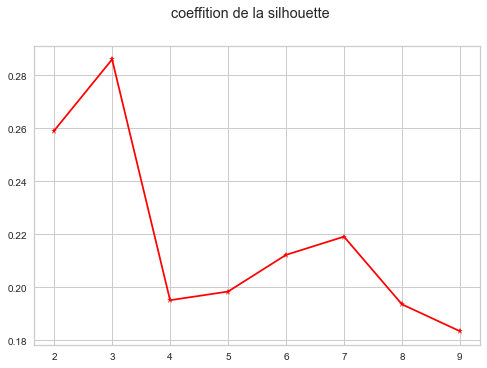

In [49]:
plt.plot(range(2,10),tab_silhouette, c="#FF0000", marker = '*')

plt.suptitle("coeffition de la silhouette")

 Le meilleur coefficient de silhouette est obtenu pour 3 clusters, ce qui semble être trop peu pour le besoin de notre problématique. Le 2ème meilleur coefficient est obtenu avec 7 clusters.

- Meilleure cohérence des clusters (Silhouette Score):

Les valeurs proches de 1 indique que les clusters sont denses est séparés

Les valeurs proches de zero indique que les clusters se mélange

Les valeurs moins de zero indique que les points peuvent être dans le mauvais cluster

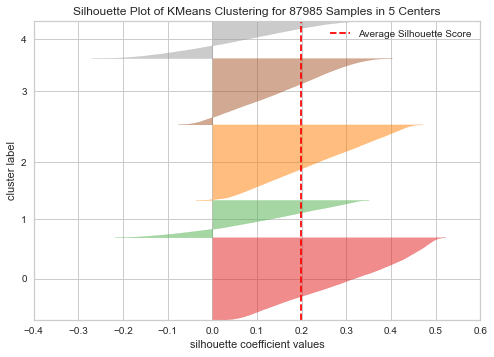

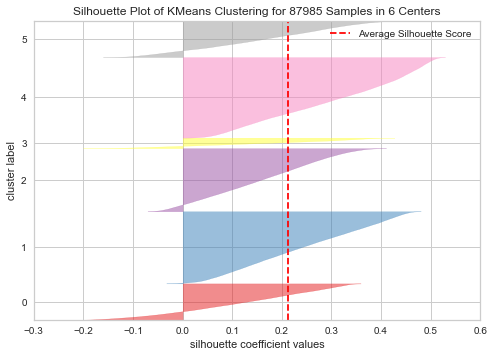

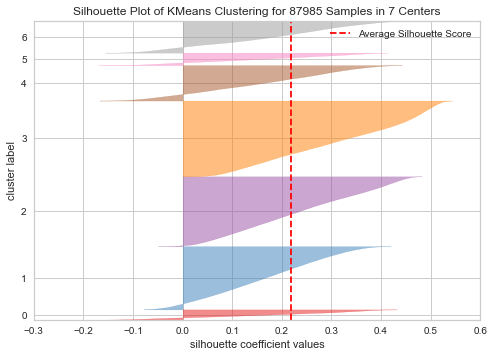

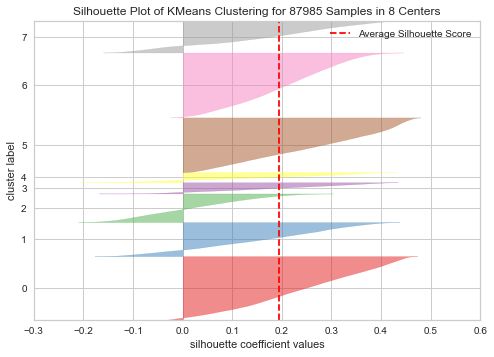

In [131]:
for i in [5,6,7,8]:
    model = KMeans(n_clusters=i, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(data_scaled)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

### Visualisation

In [50]:
#fit Kmeans avec best param

km = KMeans(n_clusters=7, random_state=42)

# Prediction
label_km = km.fit_predict(data_scaled)


In [51]:
silhouette_score(data_scaled, km.labels_)

0.21906676813027667

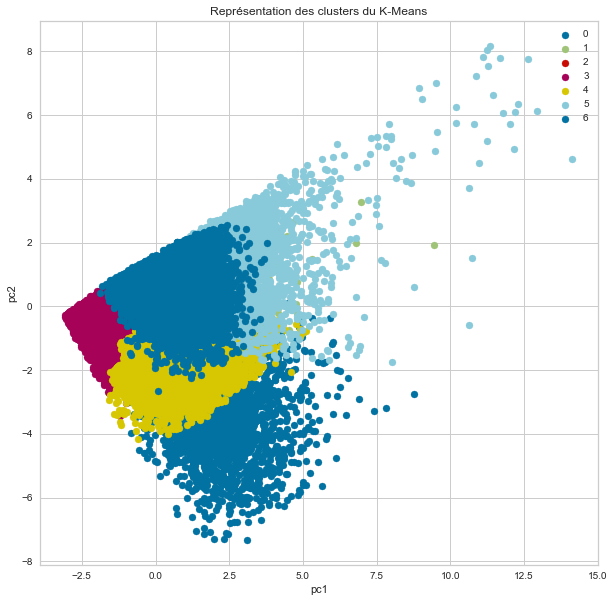

In [55]:
def  plot_PCA(labels,pca):

    u_labels = np.unique(labels)
    plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(pca[labels==i, 0], pca[labels==i, 1], label = i)
    plt.legend()
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title('Représentation des clusters du K-Means')
    plt.show()
    
plot_PCA(label_km,PCA_2d)    

### interprétation

In [56]:
rfm_custom_tolearn_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 75719 to 73776
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mean_delivery_delay             10000 non-null  float64
 1   mean_delivery_delay_estimation  10000 non-null  float64
 2   mean_payment_installments       10000 non-null  float64
 3   mean_review_score               10000 non-null  float64
 4   Recency                         10000 non-null  int64  
 5   MonetaryValue                   10000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 546.9 KB


In [57]:
data_clustered =rfm_custom_tolearn.copy()
data_clustered['Cluster'] = km.labels_
data_clustered.head()

mean_delivery_delay  mean_delivery_delay_estimation  \
0                  6.0                            10.0   
1                  3.0                             7.0   
2                 25.0                            27.0   
3                 20.0                            31.0   
4                 13.0                            20.0   

   mean_payment_installments  mean_review_score  Recency  MonetaryValue  \
0                        8.0                5.0      112         141.90   
1                        1.0                4.0      115          27.19   
2                        8.0                3.0      537          86.22   
3                        4.0                4.0      321          43.62   
4                        6.0                5.0      288         196.89   

   Cluster  
0        4  
1        3  
2        4  
3        1  
4        4

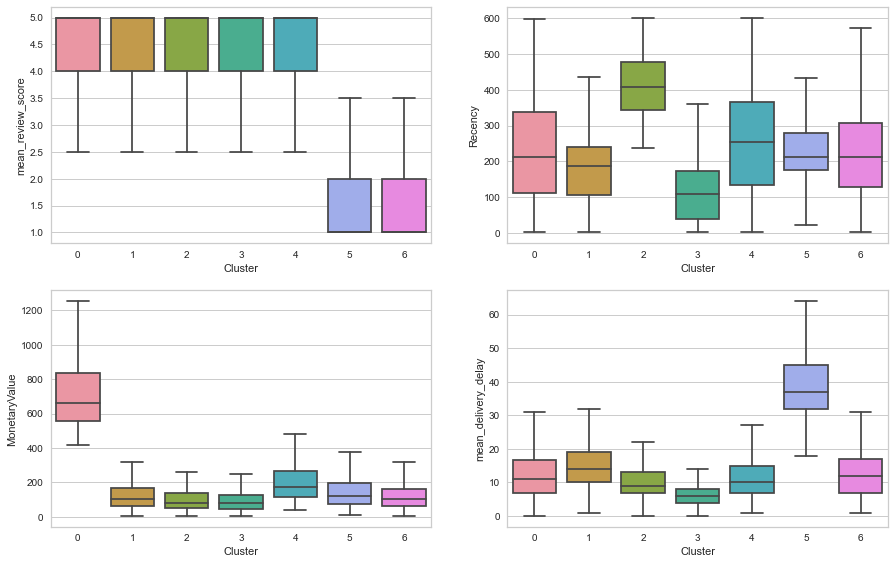

In [58]:
col_box=['mean_review_score','Recency','MonetaryValue','mean_delivery_delay']
# Visualisation graphique features selon les labels
plt.figure(figsize=(15, 20))
for col, x in zip(col_box,
                  range(1, len(data_clustered.columns))):
    plt.subplot(4, 2, x)
    sns.boxplot(y=col, x='Cluster',
                data=data_clustered, showfliers=False)
plt.show()

In [59]:
learned_data = data_clustered.copy()
learned_data['clusters']= km.labels_
data_clusters_analysis = learned_data.groupby('clusters').agg({
    'Recency' : "mean", 
    'MonetaryValue' : "mean",
    'mean_review_score': "mean",
    'mean_payment_installments':'mean',
    'mean_delivery_delay':'mean',
    'mean_delivery_delay_estimation':'mean'}).round(2)
data_clusters_analysis=data_clusters_analysis.reset_index()
data_clusters_analysis

clusters  Recency  MonetaryValue  mean_review_score  \
0         0   232.48         717.33               4.09   
1         1   178.77         125.40               4.63   
2         2   413.44         105.15               4.63   
3         3   115.73          99.82               4.68   
4         4   254.48         200.32               4.42   
5         5   241.14         151.96               1.70   
6         6   228.09         125.34               1.66   

   mean_payment_installments  mean_delivery_delay  \
0                       5.83                12.76   
1                       1.92                15.10   
2                       1.98                10.06   
3                       1.82                 6.36   
4                       7.92                11.29   
5                       3.14                41.01   
6                       2.29                12.74   

   mean_delivery_delay_estimation  
0                           25.16  
1                           30.64  
2                           23.22  
3                           15.68  
4                           24.30  
5                           28.71  
6                           22.37

In [60]:
import plotly.express as px
fig = px.parallel_coordinates(data_clusters_analysis, 
                              color="clusters",
                              dimensions=['clusters','Recency', "MonetaryValue",'mean_review_score','mean_payment_installments','mean_delivery_delay','mean_delivery_delay_estimation'],
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

Conclusion:

D'après la modélisation avec le Kmeans, il y a 7 types de clients:
 
 - 0:  client peu récent,  montant élever,  satisfait,  régle moyennement en 6 fois , La livraison a été plus rapide que l'estimation.

 - 1:  client peu récent, montant faible, très satisfait, règle en moyenne en 2 fois ,La livraison a été beaucoup plus rapide que l'estimation.
 - 2:  client ancien,  montant faible, très satisfait, règle en moyenne en 2 fois ,La livraison a été plus rapide que l'estimation.

 - 3:  client récent,  montant faible, très satisfait, règle en moyenne en 1 fois ,La livraison a été plus rapide que l'estimation.

 - 4:  client moyennement récent, montant peu élevé , satisfait, règle en moyenne en 8 fois ,La livraison a été plus rapide que l'estimation.
 - 5:  client moyennement récent, montant faible , mécontent, règle en moyenne en 3 fois ,La livraison a été plus lente que l'estimation.

 - 6:  cclient moyennement récent, montant faible , mécontent, règle en moyenne en 3 fois ,La livraison a été plus rapide que l'estimation.



## CAH

In [45]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram 
import scipy.cluster.hierarchy as shc

In [52]:
data_Agg= data_scaled.sample(10000, random_state=0).copy()

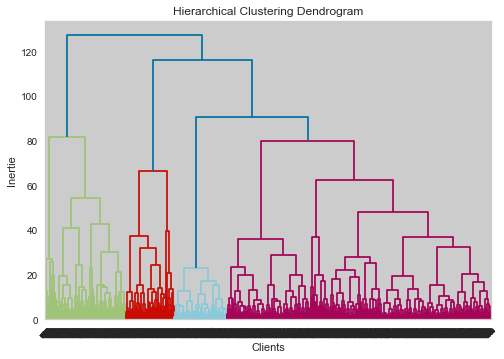

In [47]:

dendrogram = shc.dendrogram(shc.linkage(data_Agg, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Inertie')
plt.xticks(rotation=45)
plt.show()

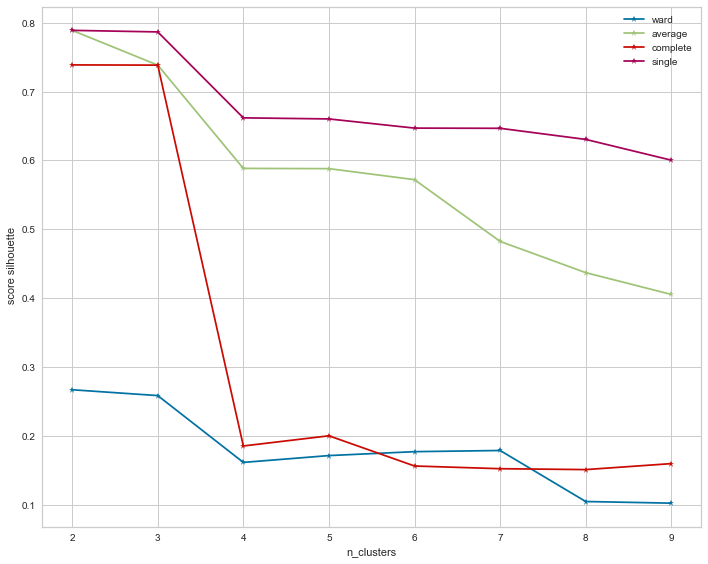

In [53]:
silhouettes_cah = {}
for linkage in ("ward", "average", "complete", "single"):
    silhouettes_cah[linkage] = []
    for n in range(2, 10) : 
        cls = AgglomerativeClustering(n_clusters=n, linkage=linkage)
        cls.fit(data_Agg)
        silhouettes_cah[linkage].append(silhouette_score(data_Agg, cls.labels_))
      
        
fig, axs = plt.subplots(figsize=(10,8))
for linkage in ("ward", "average", "complete", "single"):
    axs.plot(range(2,10), silhouettes_cah[linkage], marker='*', label=linkage)

axs.set_xlabel("n_clusters")
axs.set_ylabel(" score silhouette")
plt.tight_layout()
plt.legend()
plt.show()

In [51]:
cah = AgglomerativeClustering(n_clusters=7, linkage="ward")
cah.fit(data_Agg)
labels_cah = cah.labels_

In [ ]:
silhouette_score(data_Agg, labels_cah)

### Visualisation

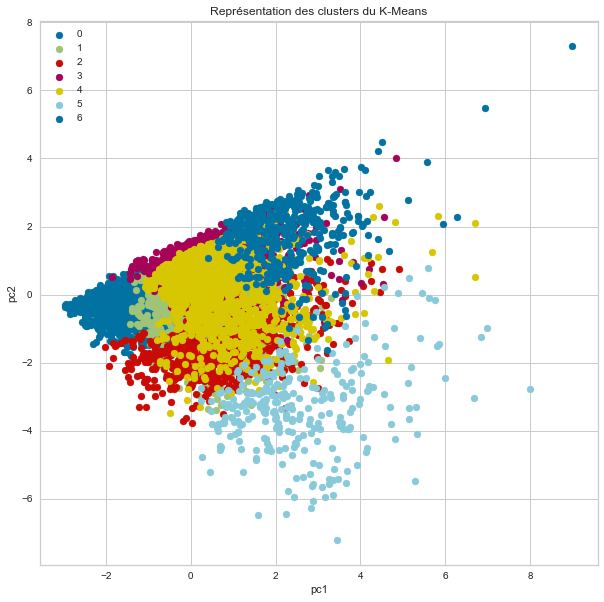

In [158]:
plot_PCA(labels_cah,pca_sample)    

### Interprétation

In [159]:
data_clustered_CAH =rfm_custom_tolearn_sample.copy()
data_clustered_CAH['Cluster'] = cah.labels_

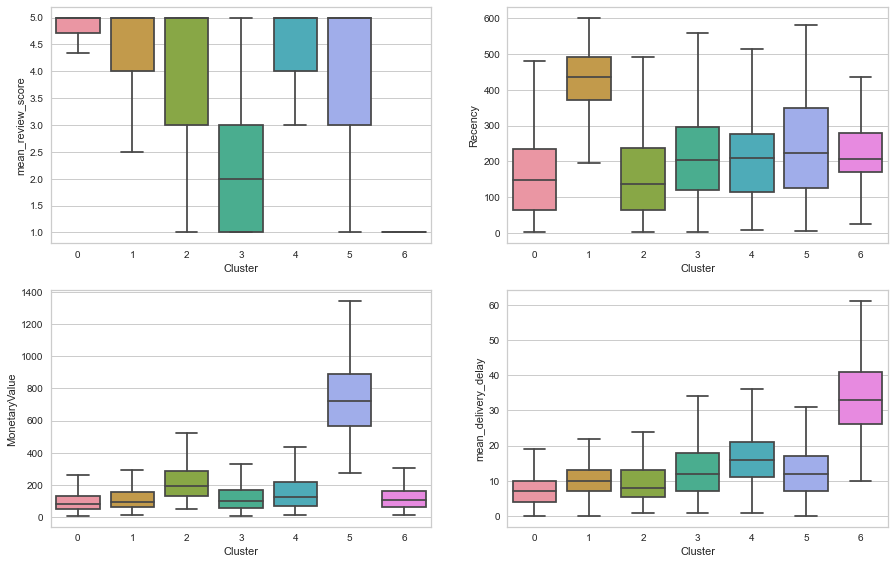

In [160]:
col_box=['mean_review_score','Recency','MonetaryValue','mean_delivery_delay']
# Visualisation graphique features selon les labels
plt.figure(figsize=(15, 20))
for col, x in zip(col_box,
                  range(1, len(data_clustered_CAH.columns))):
    plt.subplot(4, 2, x)
    sns.boxplot(y=col, x='Cluster',
                data=data_clustered_CAH, showfliers=False)
plt.show()

In [164]:

data_clusters_analysis_CAH = data_clustered_CAH.groupby('Cluster').agg({
    'Recency' : "mean", 
    'MonetaryValue' : "mean",'mean_review_score': "mean",'mean_payment_installments':'mean','mean_delivery_delay':'mean','mean_delivery_delay_estimation':'mean'}).round(2)
data_clusters_analysis_CAH = data_clusters_analysis_CAH.reset_index()
data_clusters_analysis_CAH

Cluster  Recency  MonetaryValue  mean_review_score  \
0        0   160.68          99.36               4.71   
1        1   425.39         118.05               4.63   
2        2   161.16         215.71               3.80   
3        3   223.19         125.42               1.94   
4        4   205.90         166.16               4.54   
5        5   238.03         739.87               3.93   
6        6   232.79         136.59               1.30   

   mean_payment_installments  mean_delivery_delay  \
0                       1.78                 7.36   
1                       3.49                10.25   
2                       8.14                10.48   
3                       1.93                12.73   
4                       2.32                16.76   
5                       7.43                14.82   
6                       2.49                35.40   

   mean_delivery_delay_estimation  
0                           17.96  
1                           24.82  
2                           21.22  
3                           23.60  
4                           30.73  
5                           25.53  
6                           25.97

In [165]:
fig = px.parallel_coordinates(data_clusters_analysis_CAH, 
                              color="Cluster",
                              dimensions=['Cluster','Recency', "MonetaryValue",'mean_review_score','mean_payment_installments','mean_delivery_delay'],
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

Conclusion: 

 D'après la modélisation avec le Kmeans, il y a 7 types de clients:
 - 0:clients qui ont passé leur dernière commande récemment et qui sont très satisfaits(paye en 1 fois).
 - 1:clients qui ont passé leur dernière commande y a longtemps et qui sont très satisfaits (paye en 3 fois)
 - 2:client moyennement satisfaits, paye en 8 fois un montant de 215R en moyenne.
 - 3:clients mécontents.
 - 4:clients satisfaits, en hibernation
 - 5:clients qui ont passé une commande d'un montant élevé et qui sont moyennement satisfaits
 - 6:clients mécontents. livraison plus tard que prévu.



## DBSCAN

Nous allons maintenant tester l'utilisation de l'algorithme DBSCAN pour réaliser un clustering.

In [61]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

In [62]:
data_dbscan= data_scaled.copy()

In [63]:
data_dbscan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87985 entries, 0 to 87984
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mean_delivery_delay             87985 non-null  float64
 1   mean_delivery_delay_estimation  87985 non-null  float64
 2   mean_payment_installments       87985 non-null  float64
 3   mean_review_score               87985 non-null  float64
 4   Recency                         87985 non-null  float64
 5   MonetaryValue                   87985 non-null  float64
dtypes: float64(6)
memory usage: 4.0 MB


In [65]:
eps_list = [0.5, 0.6, 0.7, 0.8]
min_samples_list = [5,7, 10, 20, 50]
dbscan_results = pd.DataFrame(
    columns=["eps", "min_samples", "number_of_clusters", "silhouette_score"]
)

for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data_dbscan)
        dbscan_results = dbscan_results.append(
            {
                "eps": eps,
                "min_samples": min_samples,
                "number_of_clusters": (np.unique(dbscan.labels_).size - 1),
                "silhouette_score": silhouette_score(data_dbscan, dbscan.labels_),
            },
            ignore_index=True,
        )

In [68]:
dbscan_results

eps  min_samples  number_of_clusters  silhouette_score
0   0.5          5.0               143.0         -0.295966
1   0.5          7.0                65.0         -0.304953
2   0.5         10.0                25.0         -0.215933
3   0.5         20.0                 2.0          0.131251
4   0.5         50.0                 4.0          0.069235
5   0.6          5.0                88.0         -0.234665
6   0.6          7.0                39.0         -0.195219
7   0.6         10.0                24.0         -0.039873
8   0.6         20.0                 2.0          0.218988
9   0.6         50.0                 2.0          0.042808
10  0.7          5.0                53.0         -0.111904
11  0.7          7.0                19.0         -0.021592
12  0.7         10.0                10.0          0.072507
13  0.7         20.0                 6.0          0.167839
14  0.7         50.0                 3.0          0.150266
15  0.8          5.0                32.0          0.061833
16  0.8          7.0                14.0          0.090704
17  0.8         10.0                 3.0          0.281698
18  0.8         20.0                 2.0          0.333144
19  0.8         50.0                 1.0          0.359776

On remarque que les meilleurs coefficients de silhouette et un nombre de clusters raisonnables sont obtenus pour eps=0.7 et min_samples=20 (score = 0.16). Analysons les clusters obtenus pour ces deux combinaisons.

In [70]:
dbscan_ = DBSCAN(eps=0.7, min_samples=20)
dbscan_.fit(data_dbscan)
dbscan_labels = dbscan_.labels_


### Visualisation

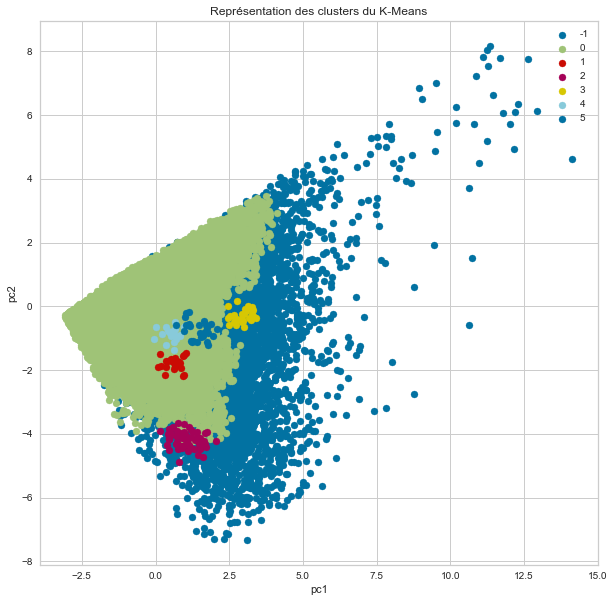

In [71]:
plot_PCA(dbscan_labels,PCA_2d) 

### Interprésation

In [72]:
data_clustered_dbscan =rfm_custom_tolearn.copy()
data_clustered_dbscan['Cluster'] = dbscan_.labels_
(data_clustered_dbscan['Cluster'].value_counts()/data_clustered_dbscan['Cluster'].value_counts().sum()).sort_values(ascending=False)

 0    0.890299
-1    0.107893
 2    0.000636
 3    0.000341
 5    0.000307
 1    0.000296
 4    0.000227
Name: Cluster, dtype: float64

 le cluster '-1' (soit 10% des clients) qui ne représente pas un cluster mais l'ensemble des clients qui n'ont pas été affectés à un cluster. ce clustering ne semble pas utilisable.

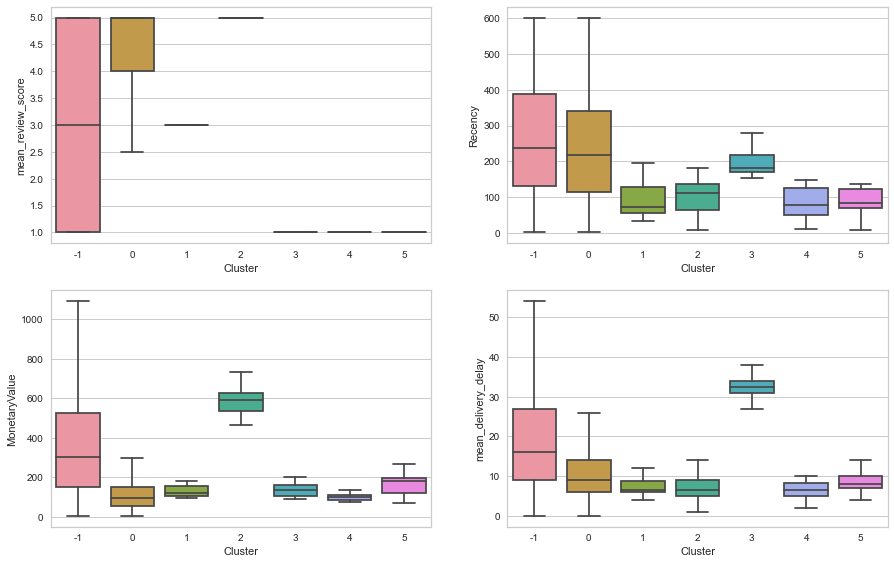

In [73]:
col_box=['mean_review_score','Recency','MonetaryValue','mean_delivery_delay']
# Visualisation graphique features selon les labels
plt.figure(figsize=(15, 20))
for col, x in zip(col_box,
                  range(1, len(data_clustered_dbscan.columns))):
    plt.subplot(4, 2, x)
    sns.boxplot(y=col, x='Cluster',
                data=data_clustered_dbscan, showfliers=False)
plt.show()

In [74]:
data_clusters_analysis_dbscan = data_clustered_dbscan.groupby('Cluster').agg({
    'Recency' : "mean", 
    'MonetaryValue' : "mean",'mean_review_score': "mean",'mean_payment_installments':'mean','mean_delivery_delay':'mean','mean_delivery_delay_estimation':'mean'}).round(2)
data_clusters_analysis_dbscan = data_clusters_analysis_dbscan.reset_index()
data_clusters_analysis_dbscan

Cluster  Recency  MonetaryValue  mean_review_score  \
0       -1   262.05         373.33               3.08   
1        0   233.43         116.65               4.29   
2        1    93.65         135.91               3.00   
3        2   102.14         591.61               5.00   
4        3   201.17         136.30               1.00   
5        4    81.90         105.51               1.00   
6        5    89.15         162.24               1.00   

   mean_payment_installments  mean_delivery_delay  \
0                       5.45                20.60   
1                       2.52                10.96   
2                       9.96                 7.04   
3                       9.98                 6.86   
4                       9.93                32.70   
5                       8.00                 6.50   
6                       7.74                 8.56   

   mean_delivery_delay_estimation  
0                           29.20  
1                           22.49  
2                           22.27  
3                           19.78  
4                           23.43  
5                           18.35  
6                           28.70

In [75]:
fig = px.parallel_coordinates(data_clusters_analysis_dbscan, 
                              color="Cluster",
                              dimensions=['Cluster','Recency', "MonetaryValue",'mean_review_score','mean_payment_installments','mean_delivery_delay','mean_delivery_delay_estimation'],
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

Conclusion:
    
    - Avec ce clustering, le bruit ('-1') représenterait le 2ème "cluster" avec  soit 10%  des clients et le 1er cluster représente 89% des clients, ce qui est également très désequilibré.
    
    - On peut donc conclure que l'algorithme DBSCAN ne semble pas approprié pour ce jeu de données.
    - Kmeans et CAH ont segmenter les clients en 7 fragment. la différence principale entre les différents types de clusters pour les deux modèles est au niveau de satisfaction des clients.  Avec Kmeans , on obient que deux types se score (1 , 4) et avec CAH on obtient (1,3,4).
    - le désavantage de CAH est qu'il est pas adapté aux grands volumes de données, le temps de calcule est très important. 